# Online Analysis

Being able to visualize and interpret simulation data in real time is
invaluable for understanding the behavior of a physical system.

SmartSim can be used to stream data from Fortran, C, and C++ simulations
to Python where visualization is significantly easier and more interactive.

This example shows how to use SmartSim analyze the vorticity field during a simple,
Python based Lattice Boltzmann fluid flow simulation.

## Lattice Boltzmann Simulation

This example was adapted from Philip Mocz's [implementation](https://github.com/pmocz/latticeboltzmann-python)
of the lattice Boltzmann method in Python. Since that example is licensed under GPL, so is this example.

Philip also wrote a great medium [article](https://medium.com/swlh/create-your-own-lattice-boltzmann-simulation-with-python-8759e8b53b1c) explaining the simulation in detail.

<img src="https://github.com/CrayLabs/SmartSim/blob/develop/doc/images/latticeboltzmann.png?raw=true" alt="lattice" width="600"/>


## Integrating SmartRedis

Typically HPC simulations are written in C, C++, Fortran or other high performance
languages. Embedding the SmartRedis client usually involves compiling in the
SmartRedis library into the simulation.

Because this simulation is written in Python, we can use the SmartRedis
Python client to stream data to the database. To make the visualization easier,
we use the SmartRedis
[Dataset](https://www.craylabs.org/docs/sr_data_structures.html#dataset) object
to hold two 2D NumPy arrays. A convenience function is provided to convert
the fields into a dataset object.


```python
    # Select lines from updated simulation code highlighting
    # the use of SmartRedis to stream data to another processes

    from smartredis import Client, Dataset
    client = Client() # Addresses passed to job through SmartSim launch

    # send cylinder location only once
    client.put_tensor("cylinder", cylinder.astype(np.int8))

    for i in range(time_steps):
        # send every 5 time_step to reduce memory consumption
        if time_step % 5 == 0:
            dataset = create_dataset(time_step, ux, uy)
            client.put_dataset(dataset)

    def create_dataset(time_step, ux, uy):
        """Create SmartRedis Dataset containing multiple NumPy arrays
        to be stored at a single key within the database"""
        dataset = Dataset(f"data_{time_step}")
        dataset.add_tensor("ux", ux)
        dataset.add_tensor("uy", uy)
        return dataset
```

This is all the SmartRedis code needed to stream the simulation data. Note that
the client does not need to have an address explicitly stated because we
are going to be launching the simulation through SmartSim as shown in the
cell below



In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from smartredis import Client
from smartsim import Experiment
from vishelpers import plot_lattice_vorticity, plot_lattice_norm, plot_lattice_probes


## Starting the Experiment

SmartSim, the infrastructure library, is used here to launch both the
database and the simulation locally, but in separate processes. The example
is designed to run on laptops, so the local launcher is used.


First the necessary libraries are imported and an `Experiment` instance is created.
An `Orchestrator` database reference is intialized and launched 
to stage data between the simulation and this notebook where we will be
performing the analysis.

In [2]:
# Initialize an Experiment with the local launcher
# This will be the name of the output directory that holds
# the output from our simulation and SmartSim
exp = Experiment("finite_volume_simulation", launcher="local")


In [3]:
# create an Orchestrator database reference,
# generate it's output directory, and launch it locally
db = exp.create_database(port=6780, interface="lo")
exp.generate(db, overwrite=True)
exp.start(db)
print(f"Database started at address: {db.get_address()}")


Database started at address: ['127.0.0.1:6780']


## Running the Simulation

To run the simulation, `Experiment.create_run_settings` is used to define how the
simulation should be executed. These settings are then passed to create a
reference to the simulation through a call to `Experiment.create_model()` which
can be used to start, monitor, and stop the simulation from this notebook.


Once the model is defined it is started by passing the reference to `Experiment.start()`
The simulation is started with the `block=False` argument. This runs the simulation
in a nonblocking manner so that the data being streamed from the simulation can be
analyzed in real time.


In [4]:
# set simulation parameters we can pass as executable arguments
time_steps, seed = 3000, 42

# create "run settings" for the simulation which define how
# the simulation will be executed when passed to Experiment.start()
settings = exp.create_run_settings("python",
                                   exe_args=["fv_sim.py",
                                             f"--seed={seed}",
                                             f"--steps={time_steps}"])

# Create the Model reference to our simulation and
# attach needed files to be copied, configured, or symlinked into
# the Model directory at runtime.
model = exp.create_model("fv_simulation", settings)
model.attach_generator_files(to_copy="fv_sim.py")
exp.generate(model, overwrite=True)


In [5]:
# start simulation without blocking so data can be analyzed in real time
exp.start(model, block=False, summary=True)


20:36:32 HPE-C02YR4ANLVCJ SmartSim[25938:MainThread] INFO 

=== Launch Summary ===
Experiment: finite_volume_simulation
Experiment Path: /home/craylabs/tutorials/online_analysis/lattice/finite_volume_simulation
Launcher: local
Models: 1
Database Status: active

=== Models ===
fv_simulation
Executable: /usr/local/anaconda3/envs/ss-py3.10/bin/python
Executable Arguments: fv_sim.py --seed=42 --steps=3000





## Online Visualization

SmartRedis is used to pull the Datasets stored in the Orchestrator
database by the simulation and use matplotlib to plot the results.

In this example, we are running the visualization in an interactive manner.
If instead we wanted to encapsulate this workflow to deploy on an HPC platform
we could have created another `Model` to plot the results and launched
in a similar manner to the simulation. Doing so would enable the analysis
application to be executed on different resources such as GPU enabled nodes,
or distributed across many nodes.


SmartRedis Library@20-36-32:WARNING: Environment variable SR_LOG_FILE is not set. Defaulting to stdout
SmartRedis Library@20-36-32:WARNING: Environment variable SR_LOG_LEVEL is not set. Defaulting to INFO


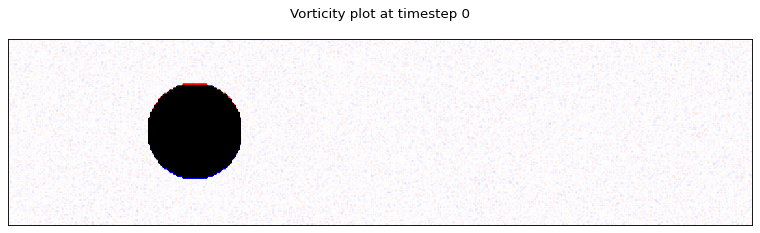

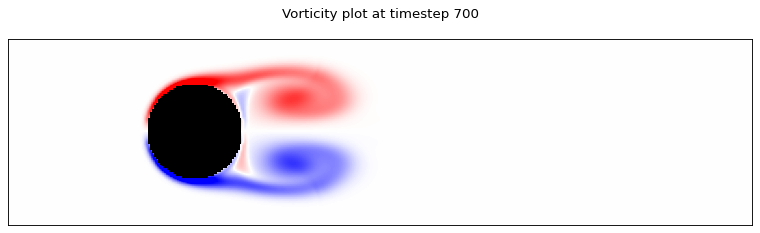

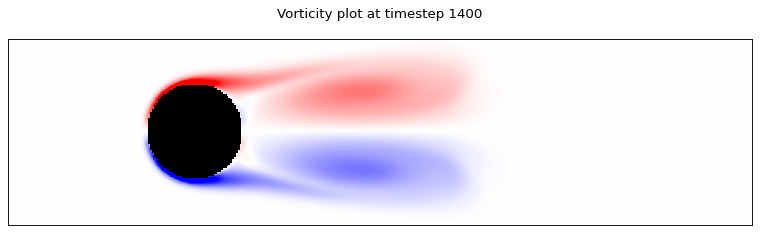

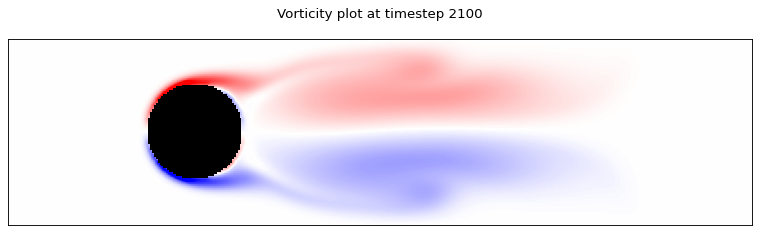

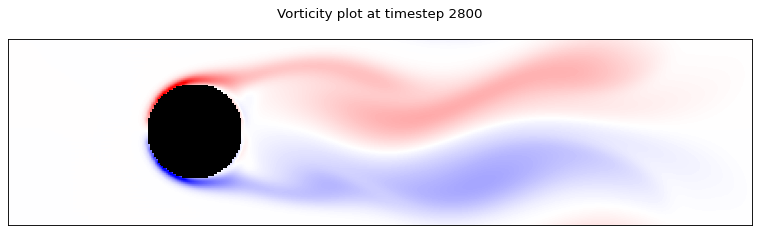

20:37:31 HPE-C02YR4ANLVCJ SmartSim[25938:JobManager] INFO fv_simulation(26039): SmartSimStatus.STATUS_COMPLETED


In [6]:
# connect a SmartRedis client to retrieve data while the
# simulation is producing it and storing it within the
# orchestrator database
client = Client(address=db.get_address()[0], cluster=False)

# Get the cylinder location in the mesh
client.poll_key(f"cylinder", 300, 1000)
cylinder = client.get_tensor("cylinder").astype(bool)

# plot every 700th timestep
for i in range(0, time_steps, 700):
    client.poll_dataset(f"data_{i}", 300, 1000)
    dataset = client.get_dataset(f"data_{i}")
    ux, uy = dataset.get_tensor("ux"), dataset.get_tensor("uy")

    plot_lattice_vorticity(i, ux, uy, cylinder)

# Use the Experiment API to wait until the model is finished
while not exp.finished(model):
    time.sleep(5)


## Post-processing with TorchScript

We can upload [TorchScript functions](https://pytorch.org/docs/2.0/jit.html) to the DB. Tensors which are stored on the DB can be passed as arguments to uploaded functions and the results will be stored on the DB. This makes it possible to perform pre- and post-processing operations on tensors localli, *in the DB*, reducing the number of data transfers.

### Uploading a script
We can load a file containing TorchScript-compatible functionsto the DB. For example, the file `./probe.script` contains the function `probe_points` which interpolates the values of `ux` and `uy` at some user-provided probe points. This is useful when we are interested in the value of a given fields only at specific locations.

The script looks like this:

```python
def multi_unsqueeze(tensor, axes: List[int]):
    for axis in axes:
        tensor = torch.unsqueeze(tensor, axis)

    return tensor

def probe_points(ux, uy, probe_x, probe_y, cylinder):
    ux[cylinder>0] = 0.0
    uy[cylinder>0] = 0.0
    ux = multi_unsqueeze(ux, [0, 0])
    uy = multi_unsqueeze(uy, [0, 0])
    probe_xy = multi_unsqueeze(torch.stack((probe_x/200 - 1, probe_y/50 - 1), 2), [0])
    u_probex = torch.grid_sampler(ux.double(), probe_xy.double(), 0, 0, False).squeeze()
    u_probey = torch.grid_sampler(uy.double(), probe_xy.double(), 0, 0, False).squeeze()

    return torch.stack((u_probex, u_probey), 2)
```

Note that we don't have to import `torch`, as the TorchScript interpreter will recognize it as a builtin module.

We then proceed to upload the script to the DB under the key `probe` and add the probe points as tensors to the DB.

In [7]:
client.set_script_from_file("probe", "./probe.script", device="CPU")

probe_x, probe_y = np.meshgrid(range(20, 400, 20), range(20, 100, 20))
client.put_tensor("probe_x", probe_x)
client.put_tensor("probe_y", probe_y)


Default@20-37-33:ERROR: Redis IO error when executing command: Failed to get reply: Resource temporarily unavailable


We then apply the function `probe_points` to the `ux` and `uy` tensors computed in the last time step of the previous simulation. Note that all tensors are already on the DB, thus we can reference them by name. Finally, we download and plot the output (a 2D velocity field), which is stored as `probe_u` on the DB.

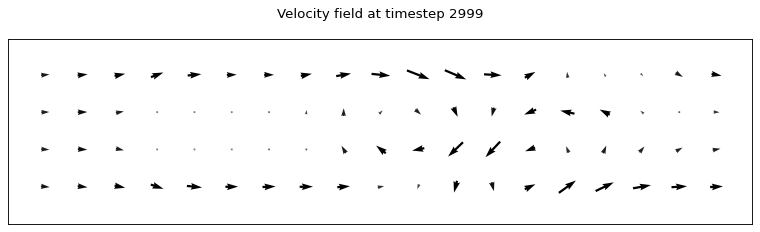

In [8]:
ux_name = f"{{data_{time_steps-1}}}.ux"
uy_name = f"{{data_{time_steps-1}}}.uy"

client.run_script("probe", "probe_points", inputs=[ux_name, uy_name , "probe_x", "probe_y", "cylinder"], outputs=["probe_u"])

probe_u = client.get_tensor("probe_u")
plot_lattice_probes(time_steps-1, probe_x, probe_y, probe_u)


### Uploading a function inline
In some cases, it makes sense to define the TorchScript function directly in a Python script or in a Jupyter notebook, like in this case. Let us define a simple function which computes the norm of the velocity field.

In [9]:
import torch

def compute_norm(ux: torch.Tensor, uy: torch.Tensor):
    return torch.sqrt(ux*ux + uy*uy)


We then store the function on the DB under the key `norm_function`.

In [10]:
client.set_function("norm_function", compute_norm)


Note that the key we used identifies a functional unit containing the function itself: this is similar to the key used to store the `probe` script above. When we want to run the function, we just call it with `run_script`, by indicating the `script` key as `"norm_function"` and the name of the function itself as `"compute_norm"`.

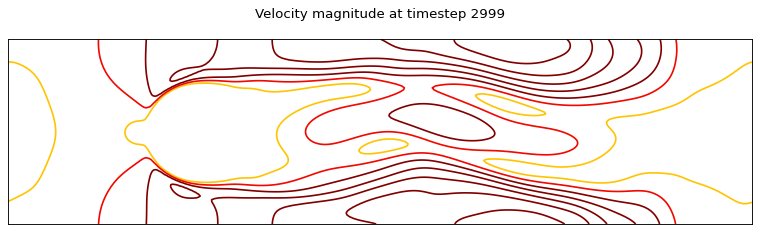

In [11]:
dataset = client.get_dataset(f"data_{time_steps-1}")
client.run_script("norm_function", "compute_norm", [f"{{data_{i}}}.uy", f"{{data_{i}}}.ux"], ["u"])
u = client.get_tensor("u")

plot_lattice_norm(time_steps-1, u, cylinder)


In [12]:
# Optionally clear the database
client.flush_db(db.get_address())


In [13]:
# terminate the database and
# release its resources
exp.stop(db)


In [14]:
exp.summary(style="html")


,Name,Entity-Type,JobID,RunID,Time,Status,Returncode
0,fv_simulation,Model,26039,0,59.2839,SmartSimStatus.STATUS_COMPLETED,0
1,orchestrator_0,DBNode,25963,0,75.2015,SmartSimStatus.STATUS_CANCELLED,0
